<a href="https://colab.research.google.com/github/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_10_4_captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google CoLab Instructions

The following code ensures that Google CoLab is running the correct version of TensorFlow.
  Running the following code will map your GDrive to ```/content/drive```.

In [1]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    print("Note: using Google CoLab")
    %tensorflow_version 2.x
except:
    print("Note: not using Google CoLab")
    COLAB = False

Mounted at /content/drive
Note: using Google CoLab


In [2]:
import os
import string
import glob
from tensorflow.keras.applications import MobileNet
import tensorflow.keras.applications.mobilenet  

from tensorflow.keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

from tqdm import tqdm
import tensorflow.keras.preprocessing.image
import pickle
from time import time
import numpy as np
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (LSTM, Embedding, 
    TimeDistributed, Dense, RepeatVector, 
    Activation, Flatten, Reshape, concatenate,  
    Dropout, BatchNormalization)
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import Input, layers
from tensorflow.keras import optimizers

from tensorflow.keras.models import Model

from tensorflow.keras.layers import add
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

START = "startseq"
STOP = "endseq"
EPOCHS = 10
USE_VGG16 = True

We use the following function to nicely format elapsed times.

In [3]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m:>02}:{s:>05.2f}"

In [4]:
if COLAB:
    root_captioning = "/content/drive/My Drive/projects/captions"
else:
    root_captioning = "./data/captions"

### Clean/Build Dataset From Flickr8k

We must pull in the Flickr dataset captions and clean them of extra whitespace, punctuation, and other distractions.

In [5]:
null_punct = str.maketrans('', '', string.punctuation)
lookup = dict()

with open( os.path.join(root_captioning,'Flickr8k_text',\
                        'Flickr8k.token.txt'), 'r') as fp:
  
  max_length = 0
  for line in fp.read().split('\n'):
    tok = line.split()
    if len(line) >= 2:
      id = tok[0].split('.')[0]
      desc = tok[1:]
      
      # Cleanup description
      desc = [word.lower() for word in desc]
      desc = [w.translate(null_punct) for w in desc]
      desc = [word for word in desc if len(word)>1]
      desc = [word for word in desc if word.isalpha()]
      max_length = max(max_length,len(desc))
      
      if id not in lookup:
        lookup[id] = list()
      lookup[id].append(' '.join(desc))
      
lex = set()
for key in lookup:
  [lex.update(d.split()) for d in lookup[key]]


The following code displays stats on the data downloaded and processed.

In [6]:
print(len(lookup)) # How many unique words
print(len(lex)) # The dictionary
print(max_length) # Maximum length of a caption (in words)


8092
8763
32


Next, we load the Glove embeddings.

In [7]:
# Warning, running this too soon on GDrive can sometimes not work.
# Just rerun if len(img) = 0
img = glob.glob(os.path.join(root_captioning,'Flicker8k_Dataset/', '*.jpg'))

Display the count of how many Glove embeddings we have.

In [8]:
len(img)

8091

Read all image names and use the predefined train/test sets.

In [9]:
train_images_path = os.path.join(root_captioning,\
            'Flickr8k_text','Flickr_8k.trainImages.txt') 
train_images = set(open(train_images_path, 'r').read().strip().split('\n'))
test_images_path = os.path.join(root_captioning,
            'Flickr8k_text','Flickr_8k.testImages.txt') 
test_images = set(open(test_images_path, 'r').read().strip().split('\n'))

train_img = []
test_img = []

for i in img:
  f = os.path.split(i)[-1]
  if f in train_images: 
    train_img.append(f) 
  elif f in test_images:
    test_img.append(f) 

Display the size of the train and test sets.

In [10]:
print(len(train_images))
print(len(test_images))

6000
1000


Build the sequences.  We include a **start** and **stop** token at the beginning/end.  We will later use the **start** token to begin the process of generating a caption.  Encountering the **stop** token in the generated text will let us know the process is complete.

In [11]:
train_descriptions = {k:v for k,v in lookup.items() if f'{k}.jpg' \
                      in train_images}
for n,v in train_descriptions.items(): 
  for d in range(len(v)):
    v[d] = f'{START} {v[d]} {STOP}'

See how many discriptions were extracted.

In [12]:
'260850192_fd03ea26f1' in train_descriptions

True

### Choosing a Computer Vision Neural Network to Transfer

This example provides two neural networks that we can use via transfer learning.  In this example, I use Glove for the text embedding and InceptionV3 to extract features from the images.  Both of these transfers serve to extract features from the raw text and the images.  Without this prior knowledge transferred in, this example would take considerably more training.

I made it so you can interchange the neural network used for the images.  By setting the values **WIDTH**, **HEIGHT**, and **OUTPUT_DIM**, you can interchange images.  One characteristic that you are seeking for the image neural network is that it does not have too many outputs (once you strip the 1000-class imagenet classifier, as is common in transfer learning).  InceptionV3 has 2,048 features below the classifier, and MobileNet has over 50K.  If the additional dimensions truly capture aspects of the images, then they are worthwhile.  However, having 50K features increases the processing needed and the complexity of the neural network we are constructing.

In [13]:
if USE_VGG16:
  encode_model = VGG16()
  encode_model = Model(encode_model.input, encode_model.layers[-2].output)
  WIDTH = 224
  HEIGHT = 224
  OUTPUT_DIM = 4096
  preprocess_input = \
    tensorflow.keras.applications.vgg16.preprocess_input
else:
  encode_model = MobileNet(weights='imagenet',include_top=False)
  WIDTH = 224
  HEIGHT = 224
  OUTPUT_DIM = 50176
  preprocess_input = tensorflow.keras.applications.mobilenet.preprocess_input

553467904/553467096 [==============================] - 24s 0us/step


The summary of the chosen image neural network to be transferred is displayed.

In [14]:
encode_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

### Creating the Training Set

We need to encode the images to create the training set.  Later we will encode new images to present them for captioning.

In [15]:
def encodeImage(img):
  # Resize all images to a standard size (specified bythe image 
  # encoding network)
  img = img.resize((WIDTH, HEIGHT), Image.ANTIALIAS)
  # Convert a PIL image to a numpy array
  x = tensorflow.keras.preprocessing.image.img_to_array(img)
  # Expand to 2D array
  x = x.reshape((1, x.shape[0], x.shape[1], x.shape[2]))
  # Perform any preprocessing needed by VGG16 or others
  x = preprocess_input(x)
  # Call VGG16 (or other) to extract the smaller feature set for 
  # the image.
  x = encode_model.predict(x, verbose = 0) # Get the encoding vector for the image
  # Shape to correct form to be accepted by LSTM captioning network.
  x = np.reshape(x, OUTPUT_DIM )
  return x

We can how to generate the training set, which will involve looping over every JPG that we provided.  Because this can take a while to perform, we will save it to a pickle file.  This saved file prevents the considerable time needed to reprocess all of the images again.  Because the images are processed differently by different transferred neural networks, the filename contains the output dimensions. We follow this naming convention because if you changed from InceptionV3 to MobileNet, the number of output dimensions would change, and you must reprocess the images.

In [16]:
train_path = os.path.join(root_captioning,"data",f'trainVGG16{OUTPUT_DIM}.pkl')
if not os.path.exists(train_path):
  start = time()
  encoding_train = {}
  for id in tqdm(train_images):
    image_path = os.path.join(root_captioning,'Flicker8k_Dataset', id)
    img = tensorflow.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    encoding_train[id] = encodeImage(img)
  with open(train_path, "wb") as fp:
    pickle.dump(encoding_train, fp)
  print(f"\nGenerating training set took: {hms_string(time()-start)}")
else:
  with open(train_path, "rb") as fp:
    encoding_train = pickle.load(fp)
    print('Loaded')

Loaded


We must also perform a similar process for the test images.

In [17]:
test_path = os.path.join(root_captioning,"data",f'testVGG16{OUTPUT_DIM}.pkl')
if not os.path.exists(test_path):
  start = time()
  encoding_test = {}
  for id in tqdm(test_img):
    image_path = os.path.join(root_captioning,'Flicker8k_Dataset', id)
    img = tensorflow.keras.preprocessing.image.load_img(image_path, \
                target_size=(HEIGHT, WIDTH))
    encoding_test[id] = encodeImage(img)
  with open(test_path, "wb") as fp:
    pickle.dump(encoding_test, fp)
  print(f"\nGenerating testing set took: {hms_string(time()-start)}")
else:
  with open(test_path, "rb") as fp:
    encoding_test = pickle.load(fp)
    print('Loaded')

Loaded


Next, we separate the captions that we will use for training.  There are two sides to this training, the images, and the captions.

In [18]:
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

30000

Words that do not occur very often can be misleading to neural network training.  It is better to remove such words.  Here we remove any words that occur less than ten times.  We display the new reduced size of the vocabulary shrunk.

In [19]:
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d ==> %d' % (len(word_counts), len(vocab)))

preprocessed words 7578 ==> 1651


Next, we build two lookup tables for this vocabulary. The table **idxtoword** converts index numbers to actual words to index values.  The **wordtoidx** lookup table performs the opposite.

In [20]:
idxtoword = {}
wordtoidx = {}

ix = 1
for w in vocab:
    wordtoidx[w] = ix
    idxtoword[ix] = w
    ix += 1
    
vocab_size = len(idxtoword) + 1 
vocab_size

1652

Previously we added a start and stop token to all sentences.  We must account for this in the maximum length of captions.

In [21]:
max_length +=2
print(max_length)

34


### Using a Data Generator

Up to this point, we've always generated training data ahead of time and fit the neural network to it.  It is not always practical to create all of the training data ahead of time.  The memory demands can be considerable.  If we generate the training data as the neural network needs it, it is possible to use a Keras generator.  The generator will create new data as it is needed.  The generator provided here creates the training data for the caption neural network, as it is needed.

If we were to build all needed training data ahead of time, it would look like Figure 10.CAP-WORK.

**Figure 10.CAP-WORK: Captioning Training Data**
![Captioning](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/caption-2.png "Captioning")

Here we are just training on two captions.  However, we would have to duplicate the image for each of these partial captions that we have.  Additionally, the Flikr8K data set has five captions for each picture.  Those would all require duplication of data as well.  It is much more efficient to generate the data as needed.

In [22]:
def data_generator(descriptions, photos, wordtoidx, \
                   max_length, num_photos_per_batch):
  # x1 - Training data for photos
  # x2 - The caption that goes with each photo
  # y - The predicted rest of the caption
  x1, x2, y = [], [], []
  n=0
  while True:
    for key, desc_list in descriptions.items():
      n+=1
      photo = photos[key+'.jpg']
      # Each photo has 5 descriptions
      for desc in desc_list:
        # Convert each word into a list of sequences.
        seq = [wordtoidx[word] for word in desc.split(' ') \
               if word in wordtoidx]
        # Generate a training case for every possible sequence and outcome
        for i in range(1, len(seq)):
          in_seq, out_seq = seq[:i], seq[i]
          in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
          out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
          x1.append(photo)
          x2.append(in_seq)
          y.append(out_seq)
      if n==num_photos_per_batch:
        yield ([np.array(x1), np.array(x2)], np.array(y))
        x1, x2, y = [], [], []
        n=0

### Loading Glove Embeddings

In [23]:
glove_dir = os.path.join(root_captioning,'glove.6B')
embeddings_index = {} 
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()
print(f'Found {len(embeddings_index)} word vectors.')

400000it [00:25, 15812.56it/s]

Found 400000 word vectors.


### Building the Neural Network

We build an embedding matrix from Glove.  We will directly copy this matrix to the weight matrix of the neural network.

In [24]:
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoidx.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

The matrix dimensions make sense.  It is 1652 (the size of the vocabulary) by 200 (the number of features Glove generates for each word).

In [25]:
embedding_matrix.shape

(1652, 200)

In [26]:
inputs1 = Input(shape=(OUTPUT_DIM,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
caption_model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [27]:
embedding_dim

200

In [28]:
caption_model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 4096)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 34, 200)      330400      input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 4096)         0           input_2[0][0]                    
_______________________________________________________________________________________

In [29]:
caption_model.layers[2].set_weights([embedding_matrix])
caption_model.layers[2].trainable = False
caption_model.compile(loss='categorical_crossentropy', optimizer='adam')

### Train the Neural Network

In [30]:
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath

In [31]:
model_path = os.path.join(root_captioning,"data",f'caption-model_VGG16.hdf5')
model_path_full = os.path.join(root_captioning,"data",f'caption-model_VGG16(Full).hdf5')
if not os.path.exists(model_path):
  for i in tqdm(range(EPOCHS*2)):
      generator = data_generator(train_descriptions, encoding_train, wordtoidx, max_length, number_pics_per_bath)
      caption_model.fit_generator(generator, epochs=1,steps_per_epoch=steps, verbose=1)

  caption_model.optimizer.lr = 1e-4
  number_pics_per_bath = 6
  steps = len(train_descriptions)//number_pics_per_bath

  for i in range(EPOCHS):
      generator = data_generator(train_descriptions, encoding_train,wordtoidx, max_length, number_pics_per_bath)
      caption_model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)  
  caption_model.save_weights(model_path)
  caption_model.save(model_path_full)
else:
  caption_model.load_weights(model_path)
  caption_model.save(model_path_full)

### Generating Captions

It is essential to understand that we do not generate a caption with one single call to the neural network's predict function.  Neural networks output a fixed-length tensor.  To get a variable-length output, such as free-form text, requires multiple calls to the neural network.

The neural network accepts two objects (which we map to the input neurons).  The first input is the photo, and the second input is an ever-growing caption.  The caption begins with just the starting token.  The neural network's output is the prediction of the next word in the caption.  The caption continues to grow until the neural network predicts an end token, or we reach the maximum length of a caption.  

In [32]:
def generateCaption(photo):
    in_text = START
    for i in range(max_length):
        sequence = [wordtoidx[w] for w in in_text.split() if w in wordtoidx]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = caption_model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idxtoword[yhat]
        in_text += ' ' + word
        if word == STOP:
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

### Evaluate Performance on Test Data from Flicker8k

The caption model performs relatively well on images that are similar to the training set.

/content/drive/My Drive/projects/captions/Flicker8k_Dataset/416106657_cab2a107a5.jpg


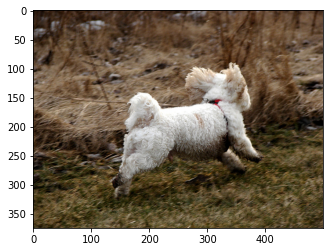

Caption: two white dogs are playing with each other
_____________________________________
/content/drive/My Drive/projects/captions/Flicker8k_Dataset/3514019869_7de4ece2a5.jpg


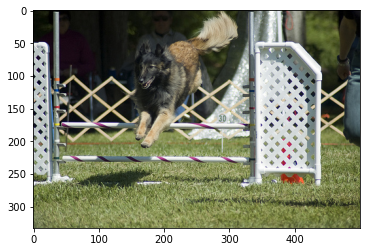

Caption: dog jumps over hurdle
_____________________________________
/content/drive/My Drive/projects/captions/Flicker8k_Dataset/2542662402_d781dd7f7c.jpg


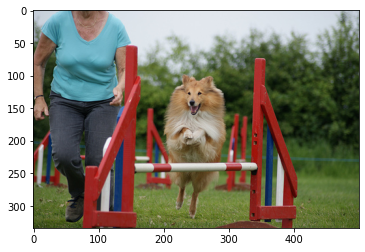

Caption: man and dog are playing with red ball
_____________________________________
/content/drive/My Drive/projects/captions/Flicker8k_Dataset/3191135894_2b4bdabb6d.jpg


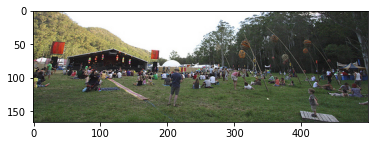

Caption: group of people are standing on the grass
_____________________________________
/content/drive/My Drive/projects/captions/Flicker8k_Dataset/106490881_5a2dd9b7bd.jpg


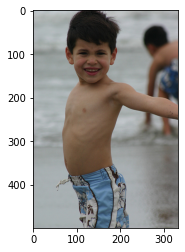

Caption: young girl in swimsuit is running on the beach
_____________________________________


In [33]:
for z in range(5): # set higher to see more examples
  pic = list(encoding_test.keys())[z]
  image = encoding_test[pic].reshape((1,OUTPUT_DIM))
  print(os.path.join(root_captioning,'Flicker8k_Dataset', pic))
  x=plt.imread(os.path.join(root_captioning,'Flicker8k_Dataset', pic))
  plt.imshow(x)
  plt.show()
  print("Caption:",generateCaption(image))
  print("_____________________________________")

In [35]:
from numpy import argmax
from pickle import load
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from nltk.translate.bleu_score import SmoothingFunction, corpus_bleu
from nltk.translate import bleu
import numpy as np
from itertools import chain

# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

# load a pre-defined list of photo identifiers
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line
		dataset.append(identifier)
	return set(dataset)

# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
			descriptions[image_id].append(desc)
	return descriptions

# load photo features
def load_photo_features(filename, dataset):
  # load all features
  all_features = load(open(filename, 'rb'))
  # filter features
  features = {k: all_features[k] for k in dataset}
  return features

# covert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# fit a tokenizer given caption descriptions
def create_tokenizer(descriptions):
	lines = to_lines(descriptions)
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer


# map an integer to a word
def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None

# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
	# seed the generation process
	in_text = 'startseq'
	# iterate over the whole length of the sequence
	for i in range(max_length):
		# integer encode input sequence
		sequence = tokenizer.texts_to_sequences([in_text])[0]
		# pad input
		sequence = pad_sequences([sequence], maxlen=max_length)
		# predict next word
		yhat = model.predict([photo,sequence], verbose=0)
		# convert probability to integer
		yhat = argmax(yhat)
		# map integer to word
		word = word_for_id(yhat, tokenizer)
		# stop if we cannot map the word
		if word is None:
			break
		# append as input for generating the next word
		in_text += ' ' + word
		# stop if we predict the end of the sequence
		if word == 'endseq':
			break
	return in_text

# map an integer to a word
def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None

# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
  # seed the generation process
  in_text = 'startseq'
  photo = np.array([photo])
  # iterate over the whole length of the sequence
  for i in range(max_length):
    # integer encode input sequence
    sequence = tokenizer.texts_to_sequences([in_text])[0]
    # pad input
    sequence = pad_sequences([sequence], maxlen=max_length)
    # predict next word
    yhat = model.predict([photo,sequence], verbose=0)
    # convert probability to integer
    yhat = argmax(yhat)
    # map integer to word
    word = word_for_id(yhat, tokenizer)
  # stop if we cannot map the word
    if word is None:
      break
  # append as input for generating the next word
    in_text += ' ' + word
    # stop if we predict the end of the sequence
    if word == 'endseq':
      break
  return in_text

def dim(a):
    if not type(a) == list:
        return []
    return [len(a)] + dim(a[0])

# evaluate the skill of the model
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
	actual, predicted = list(), list()
	actual_final, predicted_final = list(), list()
	# step over the whole set
	for key, desc_list in descriptions.items():
		# generate description
		yhat = generate_desc(model, tokenizer, photos[key], max_length)
		# store actual and predicted
		references = [d.split() for d in desc_list]
		actual.append(references)
		predicted.append(yhat.split())
	
	for temp in actual:
		for elem in temp:
			actual_final.append(elem)
	 
	predicted_final = list(chain.from_iterable(predicted)) 
	# calculate BLEU score
	act = actual
	smooth = SmoothingFunction().method4
	print('BLEU with smoothing function: %f'% bleu(actual_final, predicted_final, smoothing_function=smooth))
	print('Simple BLEU value: %f'% bleu(actual_final, predicted_final))
	print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
	print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
	print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
	print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))
	

# prepare tokenizer on train set

# load training dataset (6K)
filename = os.path.join(root_captioning, 'Flickr8k_text/Flickr_8k.trainImages.txt')
train = load_set(filename)
print('Dataset: %d' % len(train))
# descriptions
train_descriptions = load_clean_descriptions('/content/drive/My Drive/projects/captions/data/descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
# determine the maximum sequence length
print('Description Length: ', max_length)

# prepare test set

# load test set
filename = os.path.join(root_captioning, 'Flickr8k_text/Flickr_8k.testImages.txt')
test = load_set(filename)
print('Dataset: %d' % len(test)) 
# descriptions
test_descriptions = load_clean_descriptions('/content/drive/My Drive/projects/captions/data/descriptions.txt', test)
print('Descriptions: test=%d' % len(test_descriptions))
# photo features
test_features = load_photo_features('/content/drive/My Drive/projects/captions/data/testVGG164096.pkl', test)
print('Photos: test=%d' % len(test_features))

# load the model
filename = '/content/drive/My Drive/projects/captions/data/caption-model_VGG16(Full).hdf5'
model = load_model(filename)
# evaluate model
ind = evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)

Dataset: 6000
Descriptions: train=6000
Vocabulary Size: 7579
Description Length:  34
Dataset: 1000
Descriptions: test=1000
Photos: test=1000
BLEU with smoothing function: 0.009513


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Simple BLEU value: 0.012992
BLEU-1: 0.087243
BLEU-2: 0.012432
BLEU-3: 0.003908
BLEU-4: 0.009847
